# Image Super-Resolution using Bayesian Methods
Course Project for *CS 736: Medical Image Computing*, Spring 2021  
Authors: Harshit Varma and Gaurav P

## Usage: 
Modify the variables (especially `PATH_IMG` and `USE_GAUSSIAN`) present in the `'Constants'` section accordingly, and run the notebook cell by cell for testing. All results will be saved in the notebook's `'Files'` section, from where they can be downloaded.

In [732]:
# Clear all variables set
%reset -f

# Imports

In [733]:
# General
import time
import random
from tqdm.notebook import tqdm

# Image Processing
import cv2
from PIL import Image
from matplotlib import image

# Tensor Processing
import torch
import numpy as np

# Plotting
from matplotlib import pyplot as plt

# Constants/Fixed Values

In [734]:
torch.cuda.empty_cache()

In [735]:
# Reference: https://github.com/NVIDIA/framework-determinism/blob/master/pytorch.md

SEED = 20

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [736]:
# Connect to a GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE == torch.device("cuda"):
    # Empty GPU cache
    torch.cuda.empty_cache()
    # Print the GPU name
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

t = torch.cuda.get_device_properties(0).total_memory
print(f"GPU Capacity: {t / 1e9} GB")

Tesla K80
GPU Capacity: 11.996954624 GB


In [737]:
USE_GAUSSIAN = False # Whether to use the gaussian prior for HR image estimation or not. If False, the MRF prior will be used

In [738]:
PATH_IMG = "butterfly.png" # Change this accordingly

# Row x Column format is used everywhere

SHAPE_ORIG_HR = [172, 172] # original HR shape
SHAPE_PATCH_HR = [60, 60] # shape of the HR patch

UPSCALE_FACTOR = 4

SHAPE_ORIG_LR = [dim//UPSCALE_FACTOR for dim in SHAPE_ORIG_HR]
SHAPE_PATCH_LR = [dim//UPSCALE_FACTOR for dim in SHAPE_PATCH_HR]

K = 16

SIGMA_AGN = 0.01

# Likelihood weight
BETA = 0.005

HUBER_GAMMA = 0.055

# Functions

## General Functions

In [739]:
def relChange(prev, next):
    return ((prev - next) / prev)

In [740]:
def gpuMem(t):
    """ Outputs the memory occupied in MB on the GPU/CPU by the tensor t """
    mem = t.element_size() * t.nelement() # in bytes
    return mem / 10**6

In [741]:
def load(path):
    img = cv2.imread(path, 0) # Read in grayscale
    img = Image.fromarray(img) # Convert to PIL Image for downsizing
    img = img.resize((SHAPE_HR[1], SHAPE_HR[0]), Image.ANTIALIAS) # OpenCV doesn't have an ANTIALIAS option
    img = np.asarray(img) # Back to NumPy
    img = img.reshape(N, 1) # Unroll
    img = torch.from_numpy(img.copy()).to(DEVICE) # Convert to torch tensor
    img = img.float() # To FloatTensor
    img = scale(img) # Scale values in [-1/2, 1/2] as specified in the paper
    return img

In [742]:
def disp(img, out_path = None):
    """ 
        Displays an image 
        img : torch.tensor or np.array
    """

    # Convert to NumPy array
    if type(img) == torch.Tensor:
        if img.is_cuda:
            # Shift to CPU from GPU
            img = img.data.cpu().numpy()
        else:
            img = img.numpy()

    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    plt.tight_layout()

    if out_path:
        plt.savefig(out_path, dpi = 100, bbox_inches = "tight", format = "jpg", pad_inches = 0)

    plt.show()

In [743]:
def scale(img):
    """
        Scales the img to [-0.5, 0.5]
        Input: 
            img   : torch.tensor : The input image
        Output:
            img_s : torch.tensor : The scaled image
    """
    img_s = (img - torch.min(img)) / (torch.max(img) - torch.min(img)) # scale to [0, 1]
    img_s = img_s - 0.5 # scale to [-0.5, 0.5]
    img_s = img_s.float()
    return img_s

In [744]:
""" Faster logdet for SPD matrices using cholesky decomposition. 4x faster than torch.logdet """
logdetSPD = lambda X : 2*torch.cholesky(X, upper = False).diagonal(dim1 = -2, dim2 = -1).log().sum(-1)

In [745]:
def getPatch(img, shape, shape_orig, cx, cy):
    x_start = cx - shape[0]//2
    x_end   = x_start + shape[0]
    y_start = cy - shape[1]//2
    y_end   = y_start + shape[1]
    patch = img.reshape(shape_orig)
    patch = patch[x_start:x_end, y_start:y_end]
    patch = patch.reshape(-1, 1)
    return patch

In [746]:
def PSNR(x1, x2):
    x1 = scale(x1)
    x2 = scale(x2)
    mse = torch.mean((x1 - x2) ** 2)
    return 10 * torch.log10(1 / mse)

## Synthesizing LR Images

In [747]:
def positions(shape):
    """ 
        Returns the 2 x N coordinate tensor 
        Input:
            shape : List/Tuple of size 2 : Specfies the shape of the coordinate grid
        Output:
            v : torch.tensor : Flattend coordinate grid
    """
    v = np.indices(shape)
    v = v.reshape(2, -1)
    v = torch.from_numpy(v)
    v = v.float().to(DEVICE)
    return v

In [748]:
def shiftAndRotate(shape, R, s): # involves theta
    """ Returns the u_j^(k)s as defined in the paper """
    u = torch.mm(R, (V_LR - CENTER_HR)) + CENTER_HR + s
    return u

The below function is based on the following simplification:
$$
\begin{aligned}
W_{ij} &= \exp \left(\frac{-\|v_j - u_i \|^2}{\gamma^2} \right)\\
&= \exp \left(\frac{2\langle\,u_i,v_j\rangle - \|v_j\|^2 - \|u_i\|^2}{\gamma^2} \right)
\end{aligned}
$$

In [749]:
def getRotationMatrix(theta): # involves theta
    """ theta assumed to be in degrees """
    theta_rad = (np.pi / 180) * theta # To radians
    R = torch.empty(2, 2, dtype = torch.float).to(DEVICE)
    R[0, 0] = torch.cos(theta_rad)
    R[0, 1] = torch.sin(theta_rad)
    R[1, 0] = -torch.sin(theta_rad)
    R[1, 1] = torch.cos(theta_rad)
    # Doing torch.tensor(list, ...) will detach the theta from the CG as list would create copies of the tensors
    return R

In [750]:
def transform(s, theta, gamma):
    """ Returns W as defined in the paper """

    R = getRotationMatrix(theta)

    # The PSF arra
    u = shiftAndRotate(SHAPE_LR, R, s) # [2, M]

    # W[i, j] = 2*<u[i], v[j]> = 2*(u[i, 1]*v[j, 1] + u[i, 2]*v[j, 2])
    dist_sq = 2*torch.mm(u.t(), V_HR) # [M, 2] x [2, N] = [M, N]
    
    # u2[i] = u[i, 1]^2 + u[i, 2]^2 
    u2 = torch.sum(u**2, axis = 0).reshape(-1, 1) # [M, 1]

    # W[i, j] = -(|| u[i] - v[j] ||^2 / gamma^2)
    dist_sq = (dist_sq - V_HR2 - u2)

    # W[i, j] = exp(-(|| u[i] - v[j] ||^2 / gamma^2)), this takes the most time
    W = torch.exp((1 / (gamma ** 2)) * dist_sq)

    # The normalizing factor (like softmax)
    scale = torch.sum(W, dim = 1).reshape(-1, 1) # [M, 1]

    # W[i, j] = exp(-(|| u[i] - v[j] ||^2 / gamma^2)) / sum_j (exp(-(|| u[i] - v[j] ||^2 / gamma^2)))
    W = W / scale

    return W

In [751]:
def synthLRSingle(img, sigma, s = None, theta = None, gamma = None):
    """ Returns the LR image as a numpy array"""

    # Shift + Rotate + PSF
    if s == None and theta == None and gamma == None:
        sx = random.uniform(-2, 2) / 3 # Since we are using 1/3 image dims compared to the paper
        sy = random.uniform(-2, 2) / 3
        s  = torch.tensor([sx, sy], dtype = torch.float).reshape(2, 1).to(DEVICE)
        theta = torch.tensor(random.uniform(-4, 4)).to(DEVICE) / 3 # Rotation value in degrees
        gamma = 2

    W_k = transform(s, theta, gamma)

    # Additive Gaussian Noise
    eps = sigma * torch.randn(M, 1).to(DEVICE) # ~ N(0, sigma^2), sigma^2 = 1/beta in the paper

    img_lr = torch.mm(W_k, img) + eps

    img_lr = scale(img_lr)

    return img_lr

In [752]:
def getRandomShifts(a, b):
    s = (b - a)*np.random.rand(K, 2, 1) + a
    s = s.tolist()
    s = [torch.tensor(s_i, dtype = torch.float).to(DEVICE) for s_i in s]
    return s

In [753]:
def getRandomAngles(a, b):
    theta = (b - a)*np.random.rand(K, 1) + a
    theta = theta.tolist()
    theta = [torch.tensor(theta_i, dtype = torch.float).to(DEVICE) for theta_i in theta]
    return theta

In [754]:
def synthLRMultiple(img, sigma, s_list = None, theta_list = None, gamma = None):

    if s_list == None and theta_list == None and gamma == None:
        s_list = getRandomShifts(-0.65, 0.65) # ~2/3
        theta_list = getRandomAngles(-1.35, 1.35) # ~4/3
        gamma = 2

    y = [synthLRSingle(img, sigma, s_list[k], theta_list[k], gamma) for k in range(K)]

    return y, s_list, theta_list

## Prior

### Gaussian Prior

In [755]:
# Prior Parameters
PRIOR_STRENGTH = 0.04
CORR_LEN_SCALE = 1

In [756]:
def priorCovariance(A = PRIOR_STRENGTH, r = CORR_LEN_SCALE):
    """ Returns the NxN prior covariance matrix Z_x as specified in the paper """

    dist_sq = 2*torch.mm(V_HR.t(), V_HR) - V_HR2.reshape(1, -1) - V_HR2.reshape(-1, 1)

    global Zx
    Zx = A * torch.exp((1 / r ** 2) * dist_sq)

In [757]:
def logPriorGaussian(x):
    term1 = N * logdet_Zx
    term2 = torch.mm(x.t(), Zx_inv)
    term2 = torch.mm(term2, x)
    log_prior = -0.5 * (term1 + term2)
    return log_prior

### MRF Prior

In [758]:
def huber(d, h):
    abs_d  = torch.abs(d)
    mask_1 = abs_d <= h
    mask_2 = abs_d > h 
    penalty = torch.zeros(d.size(), dtype = torch.float).to(DEVICE)
    penalty[mask_1] = 0.5 * (abs_d[mask_1] ** 2)
    penalty[mask_2] = (h * abs_d[mask_2]) - 0.5*(h**2)
    return penalty

In [759]:
def neighbours(x):

    x_2d = x.reshape(SHAPE_HR)

    x_t = torch.roll(x_2d, 1, 0)
    x_b = torch.roll(x_2d, -1, 0)
    x_l = torch.roll(x_2d, 1, 1)
    x_r = torch.roll(x_2d, -1, 1)
    
    d_t = x_2d - x_t
    d_b = x_2d - x_b
    d_l = x_2d - x_l
    d_r = x_2d - x_r

    return d_t, d_b, d_l, d_r

In [760]:
def logPriorMRF(x):
    h = HUBER_GAMMA
    d_t, d_b, d_l, d_r = neighbours(x)
    log_prior = -0.5 * torch.sum(huber(d_t, h) + huber(d_b, h) + huber(d_l, h) + huber(d_r, h))
    return log_prior

## Likelihood

In [761]:
def likelihoodMean(y, W):

    term1 = torch.zeros(N, N, dtype = torch.float).to(DEVICE)
    term2 = torch.zeros(N, 1, dtype = torch.float).to(DEVICE)

    for k in range(K):
        term1 = term1 + torch.mm(W[k].t(), W[k])
        term2 = term2 + torch.mm(W[k].t(), y[k])

    mu_likelihood = torch.mm(torch.inverse(term1), term2)

    return mu_likelihood

In [762]:
def logLikelihood(x, y, W, sigma):
    term1 = (2*K*M) * np.log(sigma)
    
    term2 = torch.tensor(0, dtype = torch.float).to(DEVICE)
    for k in range(K):
        Wx = torch.mm(W[k], x)
        term2 = term2 + torch.sum((y[k] - Wx)**2)
    term2 = (1 / (sigma**2)) * term2

    log_likelihood = -0.5 * (term1 + term2)
    
    return log_likelihood

## Posterior

### Using Gaussian Prior:

In [763]:
def posteriorCovariance(W, sigma):
    
    temp = torch.zeros(N, N, dtype = torch.float).to(DEVICE)
    for k in range(K):
        temp += torch.mm(W[k].t(), W[k])

    C = torch.inverse(Zx_inv + ((1 / sigma**2) * temp)).float()
    
    return C

In [764]:
def posteriorMean(y, C, W, sigma):

    temp = torch.zeros(N, 1, dtype = torch.float).to(DEVICE)
    for k in range(K):
        temp += torch.mm(W[k].t(), y[k])

    mu = (1/sigma**2) * torch.mm(C, temp)

    return mu

In [765]:
def logPosteriorGaussian(x, y, W, sigma): # up to a constant
    log_posterior = logPriorGaussian(x) + logLikelihood(x, y, W, sigma)
    return log_posterior

### Using MRF Prior

In [766]:
def logPosteriorMRF(x, y, W, sigma):
    beta = BETA
    log_posterior = (1 - beta)*logPriorMRF(x) + beta*logLikelihood(x, y, W, sigma)
    return log_posterior

## Marginal Log Likelihood

In [767]:
def marginalLogLikelihood(y, W, C, mu, sigma):

    term1 = torch.tensor(0, dtype = torch.float).to(DEVICE)
    for k in range(K):
        Wmu = torch.mm(W[k], mu)
        term1 += torch.sum((y[k] - Wmu)**2)
    term1 = (1 / (sigma**2)) * term1

    term2 = torch.mm(Zx_inv, mu)
    term2 = torch.mm(mu.t(), term2)

    mll = -0.5 * (term1 + term2 - logdetSPD(C) + logdet_Zx + 2*K*M*np.log(sigma)) # logdet takes the most time

    return mll

# Main

In [768]:
SHAPE_HR = SHAPE_ORIG_HR
SHAPE_LR = SHAPE_ORIG_LR

N = SHAPE_HR[0] * SHAPE_HR[1]
M = SHAPE_LR[0] * SHAPE_LR[1]

CENTER_HR = [dim//2 for dim in SHAPE_HR]
CENTER_HR = torch.tensor(CENTER_HR, dtype = torch.float).reshape(2, 1).to(DEVICE)

# Pre-compute v_hr for reuse
V_HR  = positions(SHAPE_HR)
V_LR  = UPSCALE_FACTOR * positions(SHAPE_LR)
V_HR2 = torch.sum(V_HR**2, axis = 0).reshape(1, -1) # [1, N]

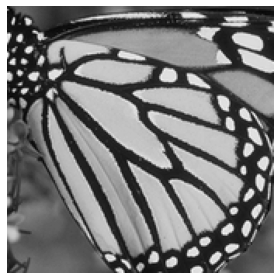

In [769]:
img = load(PATH_IMG)
disp(img.reshape(SHAPE_HR), "hr.jpg")

In [770]:
# Get the list of LR images
y, shifts_true, angles_true = synthLRMultiple(img, SIGMA_AGN)
gamma_true = 2

mkdir: cannot create directory ‘LR’: File exists


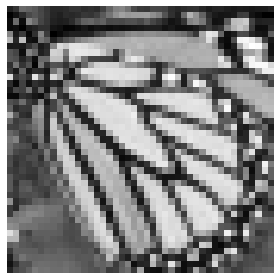

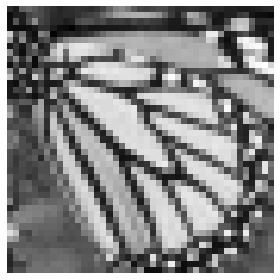

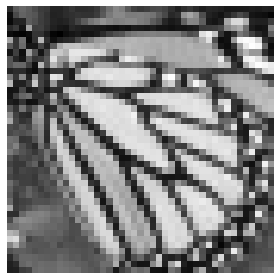

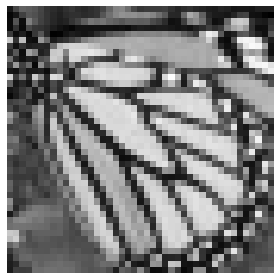

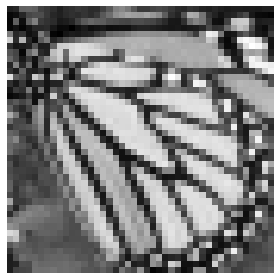

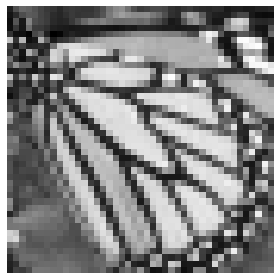

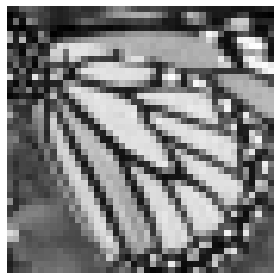

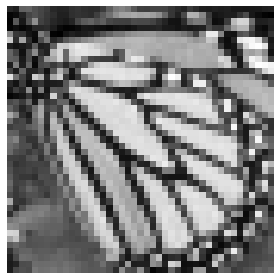

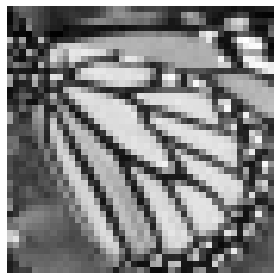

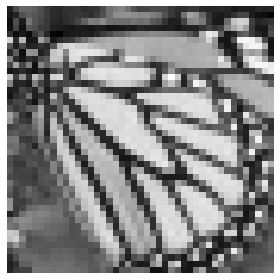

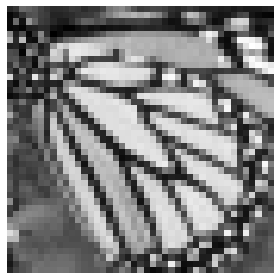

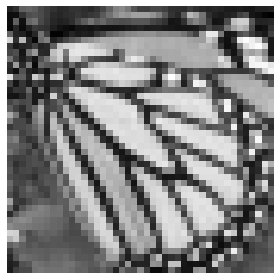

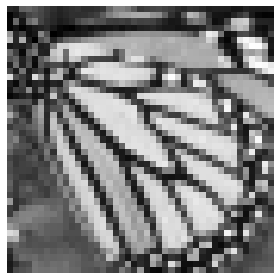

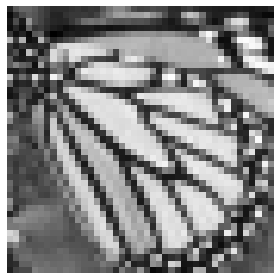

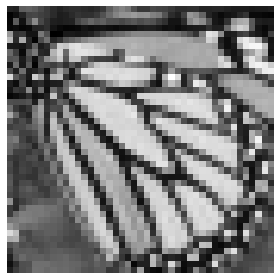

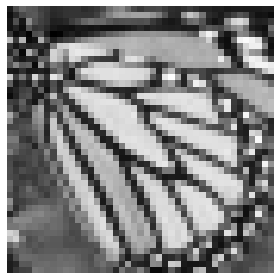

In [771]:
! mkdir LR
for k in range(K):
    disp(y[k].reshape(SHAPE_LR), f"LR/{k+1}.jpg")

In [772]:
! zip -r /content/LR.zip /content/LR

updating: content/LR/ (stored 0%)
updating: content/LR/3.jpg (deflated 4%)
updating: content/LR/1.jpg (deflated 3%)
updating: content/LR/4.jpg (deflated 3%)
updating: content/LR/14.jpg (deflated 4%)
updating: content/LR/8.jpg (deflated 4%)
updating: content/LR/16.jpg (deflated 4%)
updating: content/LR/6.jpg (deflated 4%)
updating: content/LR/2.jpg (deflated 4%)
updating: content/LR/5.jpg (deflated 4%)
updating: content/LR/10.jpg (deflated 4%)
updating: content/LR/7.jpg (deflated 4%)
updating: content/LR/9.jpg (deflated 4%)
updating: content/LR/11.jpg (deflated 4%)
updating: content/LR/12.jpg (deflated 4%)
updating: content/LR/15.jpg (deflated 3%)
updating: content/LR/13.jpg (deflated 4%)


### Crop the Input Images

In [773]:
y_patches = [getPatch(y[k], SHAPE_PATCH_LR, SHAPE_ORIG_LR, SHAPE_ORIG_LR[0]//2, SHAPE_ORIG_LR[1]//2) for k in range(K)]

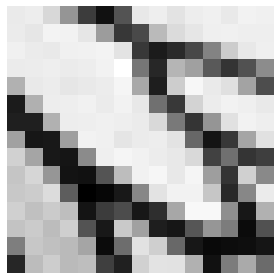

In [774]:
disp(y_patches[0].reshape(SHAPE_PATCH_LR), "patch.jpg")

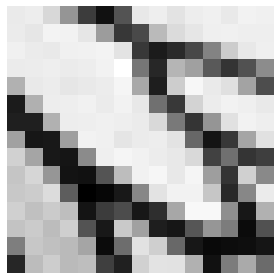

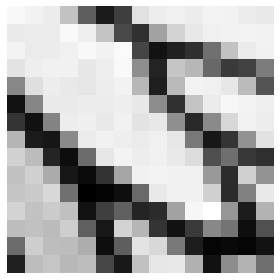

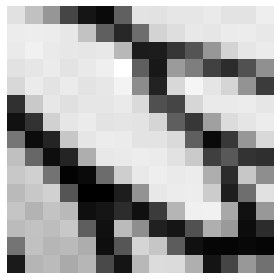

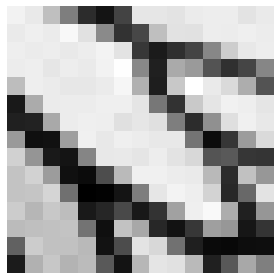

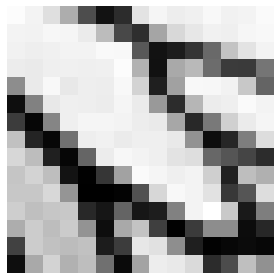

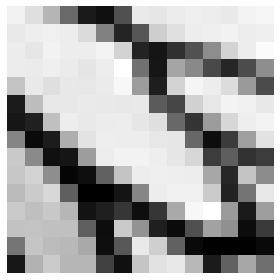

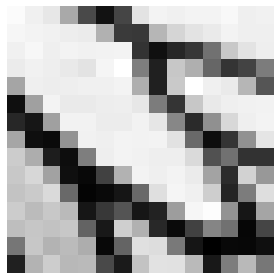

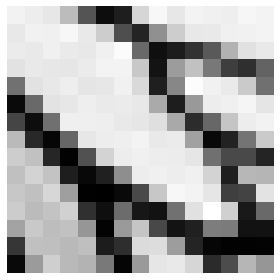

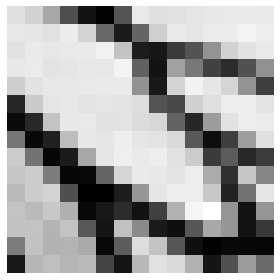

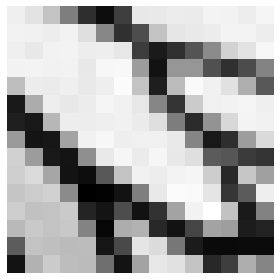

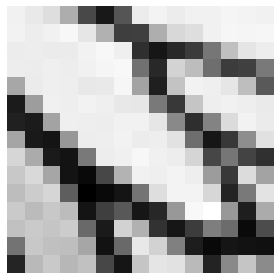

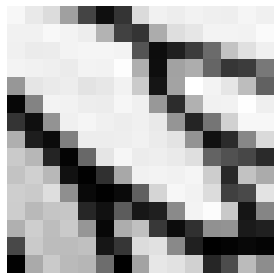

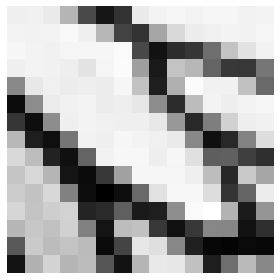

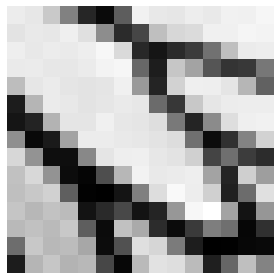

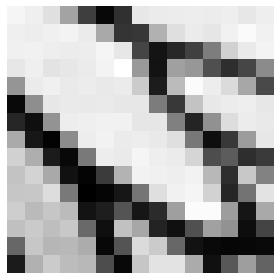

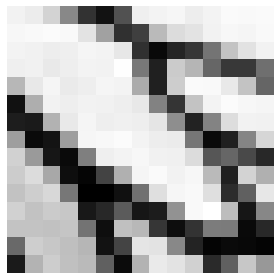

In [775]:
for k in range(K):
    disp(y_patches[k].reshape(SHAPE_PATCH_LR))

In [776]:
torch.cuda.empty_cache()

### Registration Parameters Estimation

In [777]:
SHAPE_HR = SHAPE_PATCH_HR
SHAPE_LR = SHAPE_PATCH_LR

N = SHAPE_HR[0] * SHAPE_HR[1]
M = SHAPE_LR[0] * SHAPE_LR[1]

CENTER_HR = [dim//2 for dim in SHAPE_HR]
CENTER_HR = torch.tensor(CENTER_HR, dtype = torch.float).reshape(2, 1).to(DEVICE)

# Pre-compute v_hr for reuse
V_HR  = positions(SHAPE_HR)
V_LR  = UPSCALE_FACTOR * positions(SHAPE_LR)
V_HR2 = torch.sum(V_HR**2, axis = 0).reshape(1, -1) # [1, N]

In [778]:
# Zx is constant throughout and thus is made global, thus, precompute Z_x, Z_x^{-1} and log(|Z_x)
Zx = torch.empty(N, N, dtype = torch.float).to(DEVICE)
priorCovariance() # Populates Zx
Zx_inv = torch.inverse(Zx)
logdet_Zx = logdetSPD(Zx)

# We don't need Zx anymore
del Zx
torch.cuda.empty_cache() # after this, a total of 2.03 GB is occupied

#### Optimize

In [779]:
shifts = np.zeros((K, 2, 1)) # [K, 2, 1]
shifts = shifts.tolist()
shifts = [torch.tensor(s, dtype = torch.float).to(DEVICE) for s in shifts]

In [780]:
angles = np.zeros((K, 1))
angles = angles.tolist()
angles = [torch.tensor(theta, dtype = torch.float).to(DEVICE) for theta in angles]

In [781]:
gamma = torch.tensor(UPSCALE_FACTOR, dtype = torch.float).to(DEVICE)
gamma.requires_grad  = True

In [782]:
params = [gamma]

for k in range(K):

    shifts[k].requires_grad = True
    params.append(shifts[k])

    angles[k].requires_grad = True
    params.append(angles[k])

In [783]:
N_EPOCH_MAX = 60
N_EPOCH_MIN = 60
EPS_CONVERGENCE = 1e-8
LR = 0.05 # 0.005 -> slower convergence, 0.5 -> everything goes wrong

optimizer = torch.optim.AdamW(
    params,
    lr = LR
)

In [784]:
losses = []
for i in tqdm(range(N_EPOCH_MAX)):

    optimizer.zero_grad()
    
    W = [transform(shifts[k], angles[k], gamma) for k in range(K)]
    C  = posteriorCovariance(W, SIGMA_AGN)
    mu = posteriorMean(y_patches, C, W, SIGMA_AGN)

    torch.cuda.empty_cache()

    loss = -1*marginalLogLikelihood(y_patches, W, C, mu, SIGMA_AGN)
    loss.backward()

    torch.cuda.empty_cache()

    if i > N_EPOCH_MIN:
        rel_change = relChange(losses[-1], loss.item())
        if rel_change < EPS_CONVERGENCE:
            print(f"Convergence reached, relative change in the last iteration: {rel_change}")
            break

    optimizer.step()

    loss_scalar = loss.item()
    losses.append(loss_scalar)
    print(f"Loss: {loss_scalar:.4f}") 

    torch.cuda.empty_cache() # Clears about 2GB each iteration, but still max occupied space at any time is 13.03 GB

Loss: 23909.7070
Loss: 17806.5039
Loss: 12764.4707
Loss: 8628.9824
Loss: 5301.9707
Loss: 2718.5938
Loss: 781.0215
Loss: -630.9453
Loss: -1639.8652
Loss: -2364.0488
Loss: -2907.2559
Loss: -3345.8223
Loss: -3727.1504
Loss: -4077.4609
Loss: -4411.4395
Loss: -4738.6465
Loss: -5065.9199
Loss: -5396.1113
Loss: -5727.8926
Loss: -6056.9941
Loss: -6378.1016
Loss: -6686.1699
Loss: -6976.5801
Loss: -7245.3770
Loss: -7489.6328
Loss: -7707.7383
Loss: -7899.9277
Loss: -8067.9805
Loss: -8215.2500
Loss: -8345.7891
Loss: -8463.5703
Loss: -8571.3652
Loss: -8670.3516
Loss: -8760.8340
Loss: -8843.6113
Loss: -8919.9492
Loss: -8991.6211
Loss: -9059.9844
Loss: -9126.3203
Loss: -9191.7695
Loss: -9257.1934
Loss: -9322.7090
Loss: -9387.4238
Loss: -9449.5918
Loss: -9507.7480
Loss: -9560.9121
Loss: -9608.7734
Loss: -9651.6660
Loss: -9690.1602
Loss: -9724.9395
Loss: -9756.5312
Loss: -9785.5234
Loss: -9812.3965
Loss: -9837.4512
Loss: -9860.8691
Loss: -9882.7109
Loss: -9903.2090
Loss: -9922.5957
Loss: -9941.1289
Los

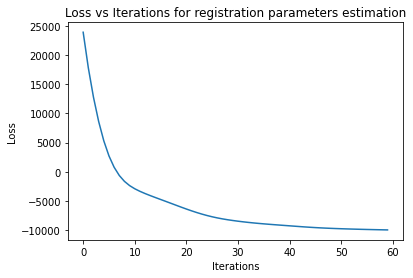

In [785]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations for registration parameters estimation")
plt.savefig("loss_reg_estimation.jpg", dpi = 100, bbox_inches = "tight", format = "jpg")
plt.show()

In [786]:
for p in params:
    p.requires_grad = False

In [787]:
shifts_list_est_x = []
shifts_list_est_y = []
shifts_list_true_x = []
shifts_list_true_y = []

angles_list_est = []
angles_list_true = []

In [788]:
for k in range(K):

    s_est = shifts[k].data.cpu().numpy()
    s_true = shifts_true[k].data.cpu().numpy()

    print(f"Shifts | True: {s_true} | Estimated: {s_est}")

    shifts_list_est_x.append(s_est[0])
    shifts_list_est_y.append(s_est[1])

    shifts_list_true_x.append(s_true[0])
    shifts_list_true_y.append(s_true[1])

    a_true = angles_true[k].item()
    a_est = angles[k].item()

    print(f"Angles | True: {a_true:.4f} | Estimated: {a_est:.4f}\n")

    angles_list_est.append(a_est)
    angles_list_true.append(a_true)

print(f"Gamma | True Gamma: {gamma_true} | Estimated: {gamma:.4f}")

Shifts | True: [[0.11457004]
 [0.51702785]] | Estimated: [[0.13993403]
 [0.57080853]]
Angles | True: -0.6243 | Estimated: -0.3997

Shifts | True: [[0.50898993]
 [0.4105887 ]] | Estimated: [[0.6157953 ]
 [0.49366146]]
Angles | True: -1.1682 | Estimated: -0.9559

Shifts | True: [[-0.60334355]
 [ 0.24928486]] | Estimated: [[-0.6010705 ]
 [ 0.25451547]]
Angles | True: 0.7329 | Estimated: 0.9592

Shifts | True: [[-0.15771477]
 [ 0.02406423]] | Estimated: [[-0.15992129]
 [ 0.0063679 ]]
Angles | True: -0.0513 | Estimated: 0.1824

Shifts | True: [[ 0.2053369 ]
 [-0.39799473]] | Estimated: [[ 0.30168223]
 [-0.3575739 ]]
Angles | True: -0.4611 | Estimated: -0.2113

Shifts | True: [[-0.29598868]
 [ 0.2841877 ]] | Estimated: [[-0.27575845]
 [ 0.36924633]]
Angles | True: 0.0287 | Estimated: 0.3368

Shifts | True: [[0.3679047 ]
 [0.45542592]] | Estimated: [[0.44269007]
 [0.53496915]]
Angles | True: -0.6382 | Estimated: -0.3965

Shifts | True: [[ 0.35781837]
 [-0.6023364 ]] | Estimated: [[ 0.48969668

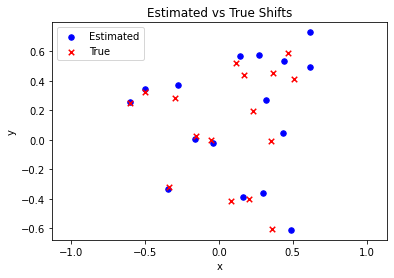

In [789]:
plt.scatter(shifts_list_est_x, shifts_list_est_y, s = 30, c = "b")
plt.scatter(shifts_list_true_x, shifts_list_true_y, s = 30, c = "r", marker = "x")
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Estimated vs True Shifts")
plt.legend(["Estimated", "True"])
plt.savefig("estimated_shifts.jpg", dpi = 100, bbox_inches = "tight", format = "jpg")
plt.show()

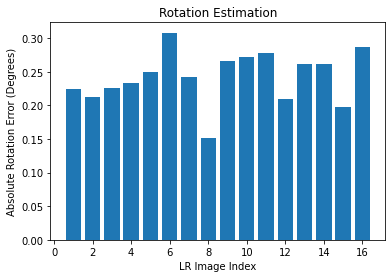

In [790]:
angles_diffs = []
for k in range(K):
    abs_diff = abs(angles_list_est[k] - angles_list_true[k])
    angles_diffs.append(abs_diff)

plt.bar(x = range(1, K+1), height = angles_diffs)
plt.xlabel("LR Image Index")
plt.ylabel("Absolute Rotation Error (Degrees)")
plt.title("Rotation Estimation")
plt.savefig("estimated_angles.jpg", dpi = 100, bbox_inches = "tight", format = "jpg")
plt.show()

In [791]:
torch.cuda.empty_cache()

## HR Image Estimation


In [792]:
SHAPE_HR = SHAPE_ORIG_HR
SHAPE_LR = SHAPE_ORIG_LR

N = SHAPE_HR[0] * SHAPE_HR[1]
M = SHAPE_LR[0] * SHAPE_LR[1]

CENTER_HR = [dim//2 for dim in SHAPE_HR]
CENTER_HR = torch.tensor(CENTER_HR, dtype = torch.float).reshape(2, 1).to(DEVICE)

# Pre-compute v_hr for reuse
V_HR  = positions(SHAPE_HR)
V_LR  = UPSCALE_FACTOR * positions(SHAPE_LR)
V_HR2 = torch.sum(V_HR**2, axis = 0).reshape(1, -1) # [1, N]

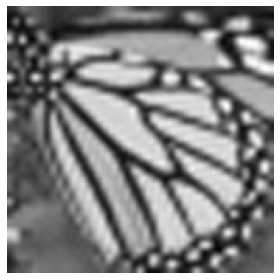

In [793]:
# Initial estimate for the HR image
X = y[0].reshape(SHAPE_LR) # Arbitrarily select the first image
X = X.data.cpu().numpy()
X = cv2.resize(X, (SHAPE_HR[1], SHAPE_HR[0]), interpolation = cv2.INTER_CUBIC)
disp(X, "sr_cubic.jpg")

In [794]:
# No need of these anymore
del Zx_inv
del logdet_Zx
torch.cuda.empty_cache()

In [795]:
if USE_GAUSSIAN:
    # Zx is constant throughout and thus is made global, thus, precompute Z_x, Z_x^{-1} and log(|Z_x)
    Zx = torch.empty(N, N, dtype = torch.float).to(DEVICE)
    priorCovariance() # Populates Zx
    Zx_inv = torch.inverse(Zx)
    logdet_Zx = logdetSPD(Zx)

    # We don't need Zx anymore
    del Zx
    torch.cuda.empty_cache() # after this, a total of 2.03 GB is occupied

In [796]:
X = X.reshape(N, 1)
X = torch.tensor(X, dtype = torch.float).to(DEVICE)
X = scale(X)
X.requires_grad = True

In [797]:
PSNR(img, X)

tensor(15.5715, device='cuda:0', grad_fn=<MulBackward0>)

In [798]:
W = [transform(shifts[k], angles[k], gamma) for k in range(K)] # actual MxN Ws, not patches

In [799]:
N_EPOCH_MAX = 100
N_EPOCH_MIN = 100
EPS_CONVERGENCE = 1e-8
LR = 0.05 

optimizer = torch.optim.AdamW(
    [X],
    lr = LR
)

In [800]:
losses = []
for i in tqdm(range(N_EPOCH_MAX)):

    optimizer.zero_grad()

    torch.cuda.empty_cache()

    if USE_GAUSSIAN:
        loss = -1*logPosteriorGaussian(X, y, W, SIGMA_AGN)
    else:
        loss = -1*logPosteriorMRF(X, y, W, SIGMA_AGN)

    loss.backward()

    torch.cuda.empty_cache()

    if i > N_EPOCH_MIN:
        rel_change = relChange(losses[-1], loss.item())
        if rel_change < EPS_CONVERGENCE:
            print(f"Convergence reached, relative change in the last iteration: {rel_change}")
            break

    optimizer.step()
    
    loss_scalar = loss.item()
    losses.append(loss_scalar)
    print(f"Loss: {loss_scalar:.4f}") 

    torch.cuda.empty_cache()

Loss: 7881.6538
Loss: 4443.2217
Loss: 2447.7773
Loss: 1338.5859
Loss: 825.6353
Loss: 651.8435
Loss: 636.8425
Loss: 672.1700
Loss: 695.2672
Loss: 676.8112
Loss: 615.9099
Loss: 528.8194
Loss: 433.1847
Loss: 339.0100
Loss: 249.6068
Loss: 167.6270
Loss: 97.3102
Loss: 41.8127
Loss: 0.5485
Loss: -30.2282
Loss: -54.5581
Loss: -75.1457
Loss: -93.8782
Loss: -112.4234
Loss: -131.7572
Loss: -151.6712
Loss: -171.3255
Loss: -190.1758
Loss: -208.0059
Loss: -224.3155
Loss: -238.2664
Loss: -249.3946
Loss: -258.0708
Loss: -265.1539
Loss: -271.3556
Loss: -277.0662
Loss: -282.5815
Loss: -288.2185
Loss: -294.1045
Loss: -300.0417
Loss: -305.6586
Loss: -310.6767
Loss: -315.0234
Loss: -318.7921
Loss: -322.1394
Loss: -325.1608
Loss: -327.8344
Loss: -330.1284
Loss: -332.1221
Loss: -333.9568
Loss: -335.7082
Loss: -337.3839
Loss: -339.0100
Loss: -340.6345
Loss: -342.2365
Loss: -343.7126
Loss: -344.9769
Loss: -346.0308
Loss: -346.9232
Loss: -347.7068
Loss: -348.4478
Loss: -349.2086
Loss: -349.9978
Loss: -350.7726

In [801]:
X.requires_grad = False

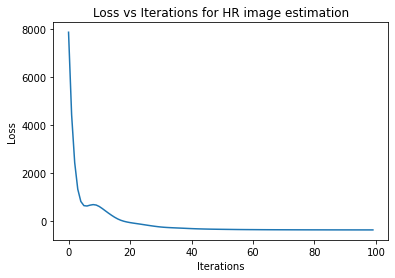

In [802]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations for HR image estimation")
plt.savefig("loss_hr_estimation.jpg", dpi = 100, bbox_inches = "tight", format = "jpg")
plt.show()

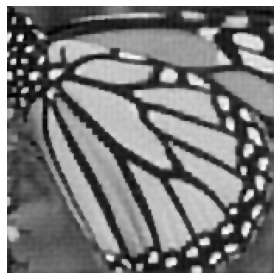

In [803]:
if USE_GAUSSIAN:
    disp(X.reshape(SHAPE_HR), "sr_gaussian_prior.jpg")
else:
    disp(X.reshape(SHAPE_HR), "sr_mrf_prior.jpg")

In [804]:
PSNR(img, X)

tensor(22.0489, device='cuda:0')